In [34]:
# dataframe management
import pandas as pd             

# numerical computation
import numpy as np

import re

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   


# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

from bokeh.layouts import gridplot
from bokeh.plotting import figure

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
output_notebook()

from datetime import datetime, timedelta, date
from scipy.stats import skew
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.datasets import load_boston

import statsmodels.api as sm


#IMPORTS FOR MODEL PARAMETRIZATION
from pprint import pprint


Loading BokehJS ...

# Functions definitions

In [35]:
def toDate(x):
    parts = [int(el) for el in x.split("/")]
    return date(parts[2], parts[1], parts[0])

def r2_cv(model, sales_train, y, random_state=12345678):
    r2= cross_val_score(model, sales_train, y, scoring="r2", cv =KFold(10, shuffle=True, random_state=random_state)) 
    return(r2)

def rmse_cv(model, sales_train, y, random_state=12345678):
    rmse= np.sqrt(-cross_val_score(model, sales_train, y, scoring="neg_mean_squared_error", cv =KFold(10, shuffle=True, random_state=random_state)))
    return(rmse)

def RegionError(region, data):
    d = data[data[region] == 1][["StoreID","Month","NumberOfSales","NumberOfPredictedSales"]].groupby(["StoreID","Month"]).agg("sum")
    res = abs(d["NumberOfSales"]-d["NumberOfPredictedSales"]).agg("sum")
    return res / d["NumberOfSales"].agg("sum")

def q(col, quant, f):
    t = sales[col].quantile(quant)
    print(f'col {col} at {quant}-th quantile => {t}')
    sales.loc[f(sales[col], t), col] = t
    
def getFilterRegion(cluster, data):
    filterRegion = data[cluster[0]] == 1
    for region in cluster[1:]:
        filterRegion = ((filterRegion) | (data[region]==1))
    return filterRegion

def getColsMatching(data, oldCol):
    return [col for col in data.columns if re.match(r"("+oldCol+"_)(\d)", col)]

def dedummify(data, oldCol):
    return data[getColsMatching(data,oldCol)].idxmax(axis=1).apply(lambda x : x.split("_")[-1])

def firstStepGetModelTrained(cluster, train):
    
    #Get only the data for the required cluster in train and test set
    train_region_label= train.loc[getFilterRegion(cluster,train)]
    print(cluster)
    
    #removing the region columns in order to force the tree alghoritm to do not split for regions
    cols_not_for_step1 = ['Region_PopulationK','Region_AreaKM2','Region_GDP',*cluster]
    train_region_columns = train_region_label[cols_not_for_step1]
    train_region_label=train_region_label.drop(columns=cols_not_for_step1)
    
    train_x_region_label_step1 = train_region_label.drop(columns=['NumberOfSales','NumberOfCustomers'])
    train_y_region_label_step1 = pd.DataFrame(data = train_region_label['NumberOfCustomers'])
    
    #First model predicting NumberOfCustomers
    model_simple = RandomForestRegressor()
    
    #finding the best parameters
    #model_simple = RandomizedSearchCV(estimator=model_simple, param_distributions=random_grid,
     #                         n_iter = 1, scoring='neg_mean_absolute_error', 
      #                        cv = 3, verbose=2, n_jobs=-1,
       #                       return_train_score=True)
    
    model_simple = model_simple.fit(train_x_region_label_step1, train_y_region_label_step1)
    
    #pprint(model_simple.best_params_)
    
    return (model_simple, cols_not_for_step1)

def secondStepGetModelTrained(train):
    train_x_step2 = train.drop(columns=['NumberOfSales'])
    train_y_step2 = pd.DataFrame(data = train['NumberOfSales']) 
    cols_for_step2 = ["NumberOfCustomers","AvgSalesForMonth","HasPromotions","AvgCustomersForMonth","Day_Of_Week_Monday","VarSalesForMonth","StoreType_Standard Market"]
    train_x_step2 = train_x_step2[cols_for_step2]
    
    #STEP2
    model_simple_step2 = RandomForestRegressor()
    
    #finding the best parameters
    model_simple_step2 = RandomizedSearchCV(estimator=model_simple_step2, param_distributions=random_grid,
                              n_iter = 10, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, n_jobs=-1,
                              return_train_score=True)
    
    model_simple_step2 = model_simple_step2.fit(train_x_step2, train_y_step2)
    
    pprint(model_simple_step2.best_params_)
    
    return (model_simple_step2, cols_for_step2)

def getModelsTrained(clusters, train_1, train):
    models = {}
    for cluster in clusters:
        models[str(cluster)] = firstStepGetModelTrained(cluster, train_1)
    # Prepare data for step2
    return models, secondStepGetModelTrained(train)


# Read input data

In [36]:
# Reading the data
sales =pd.read_csv('train.csv')
sales = sales.append(pd.read_csv('test.csv'))
# Removing tuples where stores are closed
sales = sales[sales['IsOpen'] == 1]
# Converting to category columns that are labels
for el in ["StoreID", "Region"]:
    sales[el] = sales[el].astype("category")

In [37]:
nulls = sales.isnull().sum()
sorted([(x,y) for (x,y) in zip(nulls.index, nulls) if y>0], key=lambda x: x[1], reverse=True)

[('Max_Gust_SpeedKm_h', 370184),
 ('Events', 117386),
 ('CloudCover', 41545),
 ('NumberOfCustomers', 37586),
 ('NumberOfSales', 37586),
 ('Max_VisibilityKm', 11408),
 ('Mean_VisibilityKm', 11408),
 ('Min_VisibilitykM', 11408)]

We see that Max_Gust_SpeedKm_h has 409947 missing values. We decided not to impute it.

Let's start with imputation of "Events"

In [38]:
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_missing.describe()

,CloudCover,HasPromotions,IsHoliday,IsOpen,Max_Dew_PointC,Max_Gust_SpeedKm_h,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_VisibilityKm,...,Min_TemperatureC,Min_VisibilitykM,NearestCompetitor,NumberOfCustomers,NumberOfSales,Precipitationmm,Region_AreaKM2,Region_GDP,Region_PopulationK,WindDirDegrees
count,88353.000000,117386.000000,117386.000000,117386.0,117386.000000,16279.000000,117386.000000,117386.000000,117386.000000,106405.000000,...,117386.000000,106405.000000,117386.000000,103661.000000,103661.000000,117386.000000,117386.000000,117386.000000,117386.000000,117386.000000
mean,4.972587,0.447864,0.000954,1.0,7.170906,41.117329,88.402288,1021.152931,16.380778,23.647357,...,5.941893,10.648541,8573.609102,314.641910,4893.577276,0.003462,11738.380122,13757.148229,3507.508681,138.522490
std,2.231730,0.497277,0.030874,0.0,6.222045,10.304880,9.065070,7.073287,8.454013,9.066879,...,6.504197,6.116777,12144.683666,159.283348,2238.517426,0.082444,8525.873473,2742.219077,2686.068085,105.897769
min,0.000000,0.000000,0.000000,1.0,-11.000000,23.000000,44.000000,995.000000,-9.000000,2.000000,...,-12.000000,0.000000,47.000000,0.000000,0.000000,0.000000,344.000000,9893.000000,816.000000,-1.000000
25%,3.000000,0.000000,0.000000,1.0,2.000000,34.000000,82.000000,1016.000000,10.000000,11.000000,...,1.000000,8.000000,1116.000000,215.000000,3375.000000,0.000000,7215.000000,11849.000000,1293.000000,47.000000
50%,5.000000,0.000000,0.000000,1.0,7.000000,40.000000,88.000000,1021.000000,17.000000,31.000000,...,6.000000,10.000000,3614.000000,280.000000,4461.000000,0.000000,9337.000000,13155.000000,1892.000000,129.000000
75%,7.000000,1.000000,0.000000,1.0,12.000000,47.000000,94.000000,1026.000000,23.000000,31.000000,...,11.000000,10.000000,10593.000000,372.000000,5918.000000,0.000000,15566.000000,15931.000000,5727.000000,221.000000
max,8.000000,1.000000,1.000000,1.0,23.000000,77.000000,100.000000,1042.000000,37.000000,31.000000,...,23.000000,31.000000,85070.000000,2206.000000,26641.000000,4.060000,32221.000000,23931.000000,8146.000000,360.000000


In [39]:
sales['Events'].value_counts()

Rain                           183464
Fog                             61325
Fog-Rain                        43791
Rain-Thunderstorm               18794
Rain-Snow                       16137
Snow                            12789
Fog-Rain-Thunderstorm            6546
Fog-Rain-Snow                    2696
Fog-Snow                         2469
Rain-Hail                        1647
Thunderstorm                     1298
Rain-Snow-Hail                   1133
Rain-Hail-Thunderstorm            310
Rain-Snow-Thunderstorm            307
Fog-Rain-Hail-Thunderstorm        303
Rain-Snow-Hail-Thunderstorm       290
Fog-Rain-Snow-Hail                231
Fog-Snow-Hail                     169
Fog-Rain-Hail                     168
Fog-Thunderstorm                  157
Snow-Hail                         134
Name: Events, dtype: int64

By this, we discovered that when Event is null the weather is good, from the fact that Precipitationmm mean is almost 0.
Furthermore, all the labels of Events are related to bad weather, that means that when no precipitation occurs the label is null.
We will impute Event by replacing the missing values with "Not Specified" (later).

Now we impute "CloudCover", making a distinction when it misses along with Events and when it misses on its own.

In [40]:
null_Events = sales['Events'].isnull()
null_CloudCover = sales['CloudCover'].isnull()
cloudcover_missing = sales[(null_Events)]
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_cc_missing = sales[null_CloudCover & null_Events]

cloudcover_missing.shape, event_missing.shape, event_cc_missing.shape 

((117386, 36), (117386, 36), (29033, 36))

There are 28k tuples where both "Events" and "CloudCover" are missing, that means that the weather should be good.
for the remaining (41k-28k) (i.e. where "Events" is not null!) tuples we impute the CloudCoverage.

In [41]:
event_notmissing_cc_missing = sales[null_CloudCover & ~null_Events]
#computing mean where CloudCover is not null
mean_CC = sales["CloudCover"].mean()
event_notmissing_cc_missing["CloudCover"] = event_notmissing_cc_missing["CloudCover"].fillna(mean_CC)
sales = pd.concat([sales[~null_CloudCover | null_Events], event_notmissing_cc_missing])

Then, we impute the remaining rows with CloudCover missing

In [42]:
null_Events = sales['Events'].isnull()
CloudyButNotEvent = sales[null_Events]
#there are some tuples with no Events but with the attribute CloudCover

In [43]:
null_cloudCover = sales[sales['CloudCover'].isnull()]
mean_cloudCover = sales["CloudCover"].mean()
null_cloudCover["CloudCover"] = null_cloudCover["CloudCover"].fillna(mean_cloudCover)

sales = pd.concat([sales[~sales['CloudCover'].isnull()], null_cloudCover])

Now, we impute min,max,mean_VisibilityKm. 

In [44]:
# checking if are all the same rows where visibility data are missing => yes, they are
sales[["Max_VisibilityKm", "Mean_VisibilityKm", "Min_VisibilitykM"]].count()

Max_VisibilityKm     460136
Mean_VisibilityKm    460136
Min_VisibilitykM     460136
dtype: int64

In [45]:
null_visibility = sales[sales['Max_VisibilityKm'].isnull()]
mean_vis_max = sales["Max_VisibilityKm"].mean()
mean_vis_mean = sales["Mean_VisibilityKm"].mean()
mean_vis_min = sales["Min_VisibilitykM"].mean()

null_visibility["Max_VisibilityKm"] = null_visibility["Max_VisibilityKm"].fillna(mean_vis_max)
null_visibility["Mean_VisibilityKm"] = null_visibility["Mean_VisibilityKm"].fillna(mean_vis_mean)
null_visibility["Min_VisibilitykM"] = null_visibility["Min_VisibilitykM"].fillna(mean_vis_min)

sales = pd.concat([sales[~sales['Max_VisibilityKm'].isnull()], null_visibility])

Finally, we impute "Events".

In [46]:
sales = sales.replace(np.nan,'NotSpecified', regex=True)


# Dealing with outliers

In [47]:
sales.quantile(.99).sort_values(ascending=False).head(20)

NearestCompetitor             59199.0
Region_AreaKM2                32221.0
Region_GDP                    23931.0
Region_PopulationK             8146.0
StoreID                        1741.0
Max_Sea_Level_PressurehPa      1037.0
Mean_Sea_Level_PressurehPa     1034.0
Min_Sea_Level_PressurehPa      1032.0
WindDirDegrees                  354.0
Max_Humidity                    100.0
Mean_Humidity                    99.0
Min_Humidity                     93.0
Max_Wind_SpeedKm_h               50.0
Max_TemperatureC                 32.0
Max_VisibilityKm                 31.0
Mean_Wind_SpeedKm_h              31.0
Mean_VisibilityKm                30.0
Min_VisibilitykM                 29.0
Mean_TemperatureC                24.0
Max_Dew_PointC                   20.0
Name: 0.99, dtype: float64

In [48]:
q("NearestCompetitor", .95, lambda x, y: x > y)
q("Precipitationmm", .95, lambda x, y: x > y)
q("Max_Wind_SpeedKm_h", .95, lambda x,y: x > y)
q("Max_Wind_SpeedKm_h", .03, lambda x,y: x < y)
q("Max_TemperatureC", .95, lambda x,y: x > y)
q("Max_TemperatureC", .03, lambda x,y: x < y)
q("Min_TemperatureC", .95, lambda x,y: x > y)
q("Min_TemperatureC", .03, lambda x,y: x < y)
q("Mean_Dew_PointC", .95, lambda x,y: x > y)
q("Mean_Dew_PointC", .05, lambda x,y: x < y)
q("Mean_Dew_PointC", .95, lambda x,y: x > y)
q("Mean_Dew_PointC", .05, lambda x,y: x < y)
q("Mean_Humidity", .95, lambda x,y: x > y)
q("Mean_Humidity", .03, lambda x,y: x < y)
q("Min_VisibilitykM", .95, lambda x,y: x > y)
q("Min_Humidity", .03, lambda x,y: x < y)
q("Min_Humidity", .95, lambda x,y: x > y)
q("Mean_Wind_SpeedKm_h", .95, lambda x,y: x > y)
q("Mean_TemperatureC", .03, lambda x,y: x < y)
q("Mean_TemperatureC", .95, lambda x,y: x > y)
q("Mean_VisibilityKm", .05, lambda x,y: x < y)
q("Mean_VisibilityKm", .95, lambda x,y: x > y)

col NearestCompetitor at 0.95-th quantile => 31706.399999986403
col Precipitationmm at 0.95-th quantile => 5.08
col Max_Wind_SpeedKm_h at 0.95-th quantile => 39.0
col Max_Wind_SpeedKm_h at 0.03-th quantile => 11.0
col Max_TemperatureC at 0.95-th quantile => 27.0
col Max_TemperatureC at 0.03-th quantile => 1.0
col Min_TemperatureC at 0.95-th quantile => 16.0
col Min_TemperatureC at 0.03-th quantile => -5.0
col Mean_Dew_PointC at 0.95-th quantile => 15.0
col Mean_Dew_PointC at 0.05-th quantile => -3.0
col Mean_Dew_PointC at 0.95-th quantile => 15.0
col Mean_Dew_PointC at 0.05-th quantile => -3.0
col Mean_Humidity at 0.95-th quantile => 94.0
col Mean_Humidity at 0.03-th quantile => 49.0
col Min_VisibilitykM at 0.95-th quantile => 11.0
col Min_Humidity at 0.03-th quantile => 19.0
col Min_Humidity at 0.95-th quantile => 83.0
col Mean_Wind_SpeedKm_h at 0.95-th quantile => 24.0
col Mean_TemperatureC at 0.03-th quantile => -2.0
col Mean_TemperatureC at 0.95-th quantile => 21.0
col Mean_Visibil

# Normalization of Numerical Variables

Text(0.5,1,'')

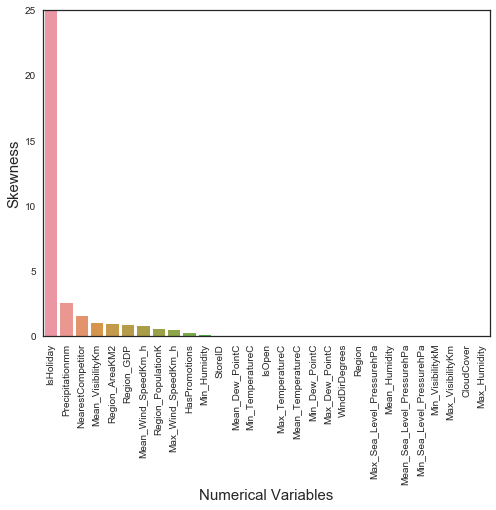

In [49]:
# take the numerical features
numeric_feats = sales.dtypes[sales.dtypes != "object"].index
# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = sales[numeric_feats].apply(lambda x: skew(x.dropna()))

skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.data})
# select the variables with a skewness above a certain threshold
skewness = skewness.sort_values('Skewness', ascending=[0])
f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

In [50]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.drop(['IsHoliday'])#,'NumberOfCustomers', "NumberOfSales"])
sales[skewed_feats.index] = np.log1p(sales[skewed_feats.index])

# Correlation Analysis and Feature Selection

By analyzing the correlation, we see that the following variables do not add any additional information. 
Max_Dew_PointC, Min_Dew_PointC, Max_Sea_Level_PressurehPa, Mean_Sea_Level_PressurehPa, Max_Gust_SpeedKm_h
Finally, we drop 'NumberOfCustomers' because is not present in the submission dataset.

In [51]:
sales=sales.drop(columns=['Max_Dew_PointC','Min_Dew_PointC','Max_Sea_Level_PressurehPa','Mean_Sea_Level_PressurehPa','Max_Gust_SpeedKm_h'])
sales.shape

(471544, 31)

Drop of the row where IsOpen==0

In [52]:
sales=sales[sales['IsOpen']==1]
sales=sales.drop(columns=['IsOpen'])

### Convert Date to weekday label

In [53]:
sales["Date"] = sales["Date"].apply(toDate)
sales["Day_Of_Week"] = sales["Date"].astype("datetime64").dt.weekday_name

### Convert Date to month label

In [54]:
sales["Month"] = sales["Date"].astype("datetime64").dt.month

### Adding info about avgsales per month ecc.

In [55]:
avgSalesForStoreIDForMonth = sales[sales["NumberOfSales"] != 'NotSpecified']
avgSalesForStoreIDForMonth["NumberOfSales"] = avgSalesForStoreIDForMonth["NumberOfSales"].astype("int")
avgSalesForStoreIDForMonth = avgSalesForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfSales'].mean() 
avgSalesForStoreIDForMonth = avgSalesForStoreIDForMonth.rename(index=str, columns={"NumberOfSales": "AvgSalesForMonth"})

varSalesForStoreIDForMonth = sales[sales["NumberOfSales"] != 'NotSpecified']
varSalesForStoreIDForMonth["NumberOfSales"] = varSalesForStoreIDForMonth["NumberOfSales"].astype("int")
varSalesForStoreIDForMonth = varSalesForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfSales'].var() 
varSalesForStoreIDForMonth = varSalesForStoreIDForMonth.rename(index=str, columns={"NumberOfSales": "VarSalesForMonth"})

avgCustomersForStoreIDForMonth = sales[sales["NumberOfCustomers"] != 'NotSpecified']
avgCustomersForStoreIDForMonth["NumberOfCustomers"] = avgCustomersForStoreIDForMonth["NumberOfCustomers"].astype("int")
avgCustomersForStoreIDForMonth = avgCustomersForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfCustomers'].mean() 
avgCustomersForStoreIDForMonth = avgCustomersForStoreIDForMonth.rename(index=str, columns={"NumberOfCustomers": "AvgCustomersForMonth"})

varCustomersorStoreIDForMonth = sales[sales["NumberOfSales"] != 'NotSpecified']
varCustomersorStoreIDForMonth["NumberOfCustomers"] = varCustomersorStoreIDForMonth["NumberOfCustomers"].astype("int")
varCustomersorStoreIDForMonth = varCustomersorStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfCustomers'].var() 
varCustomersorStoreIDForMonth = varCustomersorStoreIDForMonth.rename(index=str, columns={"NumberOfCustomers": "VarCustomersForMonth"})

sales = sales.merge(avgSalesForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month']) 
sales = sales.merge(varSalesForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month'])
sales = sales.merge(avgCustomersForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month']) 
sales = sales.merge(varCustomersorStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month'])

# Dummify variables

In [56]:
sales = pd.get_dummies(sales, columns=['StoreType','Events','AssortmentType', "Region", "Day_Of_Week","Month"])

# Random Search With Crossvalidation

In [57]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


# Train and Test Definition
Separating the last 2 months, and use those as a test set and comparing the total of the predicted values.

In [58]:
start_train = date(2018, 3, 1)
train = sales[sales["Date"] - start_train < timedelta(0)]
test = sales[sales["Date"] - start_train > timedelta(days=1)]
train = train.drop(columns=["Date"])
test = test.drop(columns=["Date"])
test = test.drop(columns=["NumberOfCustomers","NumberOfSales"])

In [59]:
train.NumberOfSales = train.NumberOfSales.astype('int')
train.NumberOfCustomers = train.NumberOfCustomers.astype('int')

In [60]:
cols_not_for_step1 = ["NumberOfCustomers","NumberOfSales",'Region_PopulationK','Region_AreaKM2','Region_GDP','Region_0','Region_1','Region_4','Region_5','Region_7','Region_8','Region_10','Region_2','Region_3', 'Region_6', 'Region_9'
]
train_saved_columns = train[cols_not_for_step1]


In [61]:
train_x = train.drop(columns=['NumberOfSales','NumberOfCustomers'])
train_y = pd.DataFrame(data = train['NumberOfCustomers'])
    
#First model predicting NumberOfCustomers
model_simple = RandomForestRegressor()
model_simple = model_simple.fit(train_x, train_y)

Variable: AvgCustomersForMonth Importance: 0.84
Variable: HasPromotions        Importance: 0.04
Variable: Min_Sea_Level_PressurehPa Importance: 0.01
Variable: VarSalesForMonth     Importance: 0.01
Variable: VarCustomersForMonth Importance: 0.01
Variable: Day_Of_Week_Monday   Importance: 0.01
Variable: Day_Of_Week_Saturday Importance: 0.01
Variable: CloudCover           Importance: 0.0
Variable: IsHoliday            Importance: 0.0
Variable: Max_Humidity         Importance: 0.0
Variable: Max_TemperatureC     Importance: 0.0
Variable: Max_VisibilityKm     Importance: 0.0
Variable: Max_Wind_SpeedKm_h   Importance: 0.0
Variable: Mean_Dew_PointC      Importance: 0.0
Variable: Mean_Humidity        Importance: 0.0
Variable: Mean_TemperatureC    Importance: 0.0
Variable: Mean_VisibilityKm    Importance: 0.0
Variable: Mean_Wind_SpeedKm_h  Importance: 0.0
Variable: Min_Humidity         Importance: 0.0
Variable: Min_TemperatureC     Importance: 0.0
Variable: Min_VisibilitykM     Importance: 0.0
V

'# Train the expanded model on only the important features\nmodel_simple = RandomForestRegressor()\nmodel_simple = model_simple.fit(important_train_features, train_y);'

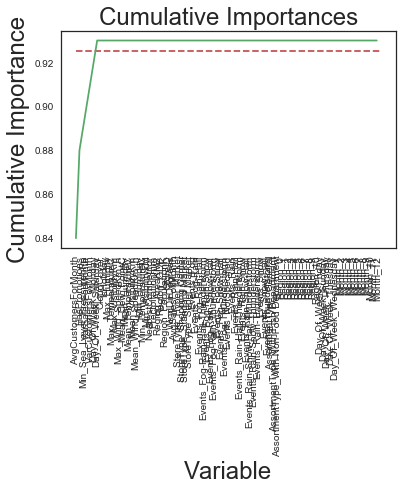

In [62]:
# Get numerical feature importances
importances = list(model_simple.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train_x, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
# list of x locations for plotting
x_values = list(range(len(importances)))
    
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 92,5% of importance retained
plt.hlines(y = 0.925, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
    
# Find number of features for cumulative importance of 92,5%
# Add 1 because Python is zero-indexed
print('Number of features for 92,5% importance:', np.where(cumulative_importances > 0.925)[0][0] + 1)
    
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:6]]
    
# Find the columns of the most important features
important_indices = [list(train.columns).index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = train_x.values[:, important_indices]
important_test_features = test.values[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)
        
'''# Train the expanded model on only the important features
model_simple = RandomForestRegressor()
model_simple = model_simple.fit(important_train_features, train_y);'''
    

In [63]:
important_train_features = pd.DataFrame(data=important_train_features)
important_test_features = pd.DataFrame(data=important_test_features)

In [64]:
important_train_features[train_saved_columns.columns]=train_saved_columns
important_test_features[train_saved_columns.columns]=train_saved_columns

important_test_features = important_test_features.drop(columns=["NumberOfCustomers","NumberOfSales"])



Clusterization of regions which are similar or with too few samples to be fitted on their own.
Used t-sne to visualize clusters

In [65]:
Region_labels = [['Region_0', 'Region_1', 'Region_4','Region_5','Region_7', 'Region_8', 'Region_10' ], ['Region_2'], ['Region_3'], ['Region_6', 'Region_9']]
# it can be useful to move also region 6 in the first big cluster

In [66]:
m_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)

['Region_0', 'Region_1', 'Region_4', 'Region_5', 'Region_7', 'Region_8', 'Region_10']
['Region_2']
['Region_3']
['Region_6', 'Region_9']
Fitting 3 folds for each of 10 candidates, totalling 30 fits


JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\santa\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\santa\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000024AD45A5ED0, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\santa\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\santa\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\s...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000024AD45A5ED0, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\santa\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\santa\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\s...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'm_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 10, 12, 23, 49, 324845, tzinfo=tzutc()), 'msg_id': 'ffd9308bee41474385e54ee079bb9f11', 'msg_type': 'execute_request', 'session': '7b2494c09ffd4e8f926b35042e841658', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ffd9308bee41474385e54ee079bb9f11', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'7b2494c09ffd4e8f926b35042e841658']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'm_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 10, 12, 23, 49, 324845, tzinfo=tzutc()), 'msg_id': 'ffd9308bee41474385e54ee079bb9f11', 'msg_type': 'execute_request', 'session': '7b2494c09ffd4e8f926b35042e841658', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ffd9308bee41474385e54ee079bb9f11', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'7b2494c09ffd4e8f926b35042e841658'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'm_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 10, 12, 23, 49, 324845, tzinfo=tzutc()), 'msg_id': 'ffd9308bee41474385e54ee079bb9f11', 'msg_type': 'execute_request', 'session': '7b2494c09ffd4e8f926b35042e841658', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ffd9308bee41474385e54ee079bb9f11', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='m_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'm_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('m_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('m_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='m_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-66-6c48b3388410>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 24a8f15d080, executio..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000024ADCA74390, file "<ipython-input-66-6c48b3388410>", line 1>
        result = <ExecutionResult object at 24a8f15d080, executio..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000024ADCA74390, file "<ipython-input-66-6c48b3388410>", line 1>, result=<ExecutionResult object at 24a8f15d080, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000024ADCA74390, file "<ipython-input-66-6c48b3388410>", line 1>
        self.user_global_ns = {'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'CloudyButNotEvent':                  AssortmentType  CloudCover     ...ket              21  

[117386 rows x 36 columns], 'ColumnDataSource': <class 'bokeh.models.sources.ColumnDataSource'>, 'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'In': ['', '# dataframe management\nimport pandas as pd      ...R MODEL PARAMETRIZATION\nfrom pprint import pprint', 'def toDate(x):\n    parts = [int(el) for el in x....  return models, secondStepGetModelTrained(train)', '# Reading the data\nsales =pd.read_csv(\'train.csv...n"]:\n    sales[el] = sales[el].astype("category")', 'nulls = sales.isnull().sum()\nsorted([(x,y) for (...nulls) if y>0], key=lambda x: x[1], reverse=True)', "null_Events = sales['Events'].isnull()\nevent_missing = sales[null_Events]\nevent_missing.describe()", "sales['Events'].value_counts()", "null_Events = sales['Events'].isnull()\nnull_Clou...ape, event_missing.shape, event_cc_missing.shape ", 'event_notmissing_cc_missing = sales[null_CloudCo...ver | null_Events], event_notmissing_cc_missing])', "null_Events = sales['Events'].isnull()\nCloudyBut... with no Events but with the attribute CloudCover", "null_cloudCover = sales[sales['CloudCover'].isnu...~sales['CloudCover'].isnull()], null_cloudCover])", '# checking if are all the same rows where visibi..."Mean_VisibilityKm", "Min_VisibilitykM"]].count()', "null_visibility = sales[sales['Max_VisibilityKm'...['Max_VisibilityKm'].isnull()], null_visibility])", "sales = sales.replace(np.nan,'NotSpecified', regex=True)", 'sales.quantile(.99).sort_values(ascending=False).head(20)', 'q("NearestCompetitor", .95, lambda x, y: x > y)\n...y)\nq("Mean_VisibilityKm", .95, lambda x,y: x > y)', "# take the numerical features\nnumeric_feats = sa...kewness', fontsize=15)\nplt.title('', fontsize=15)", 'skewed_feats = skewed_feats[skewed_feats > 0.75]...eats.index] = np.log1p(sales[skewed_feats.index])', "sales=sales.drop(columns=['Max_Dew_PointC','Min_...l_PressurehPa','Max_Gust_SpeedKm_h'])\nsales.shape", "sales=sales[sales['IsOpen']==1]\nsales=sales.drop(columns=['IsOpen'])", ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'Lasso': <class 'sklearn.linear_model.coordinate_descent.Lasso'>, 'LassoCV': <class 'sklearn.linear_model.coordinate_descent.LassoCV'>, 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, ...}
        self.user_ns = {'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'CloudyButNotEvent':                  AssortmentType  CloudCover     ...ket              21  

[117386 rows x 36 columns], 'ColumnDataSource': <class 'bokeh.models.sources.ColumnDataSource'>, 'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'In': ['', '# dataframe management\nimport pandas as pd      ...R MODEL PARAMETRIZATION\nfrom pprint import pprint', 'def toDate(x):\n    parts = [int(el) for el in x....  return models, secondStepGetModelTrained(train)', '# Reading the data\nsales =pd.read_csv(\'train.csv...n"]:\n    sales[el] = sales[el].astype("category")', 'nulls = sales.isnull().sum()\nsorted([(x,y) for (...nulls) if y>0], key=lambda x: x[1], reverse=True)', "null_Events = sales['Events'].isnull()\nevent_missing = sales[null_Events]\nevent_missing.describe()", "sales['Events'].value_counts()", "null_Events = sales['Events'].isnull()\nnull_Clou...ape, event_missing.shape, event_cc_missing.shape ", 'event_notmissing_cc_missing = sales[null_CloudCo...ver | null_Events], event_notmissing_cc_missing])', "null_Events = sales['Events'].isnull()\nCloudyBut... with no Events but with the attribute CloudCover", "null_cloudCover = sales[sales['CloudCover'].isnu...~sales['CloudCover'].isnull()], null_cloudCover])", '# checking if are all the same rows where visibi..."Mean_VisibilityKm", "Min_VisibilitykM"]].count()', "null_visibility = sales[sales['Max_VisibilityKm'...['Max_VisibilityKm'].isnull()], null_visibility])", "sales = sales.replace(np.nan,'NotSpecified', regex=True)", 'sales.quantile(.99).sort_values(ascending=False).head(20)', 'q("NearestCompetitor", .95, lambda x, y: x > y)\n...y)\nq("Mean_VisibilityKm", .95, lambda x,y: x > y)', "# take the numerical features\nnumeric_feats = sa...kewness', fontsize=15)\nplt.title('', fontsize=15)", 'skewed_feats = skewed_feats[skewed_feats > 0.75]...eats.index] = np.log1p(sales[skewed_feats.index])', "sales=sales.drop(columns=['Max_Dew_PointC','Min_...l_PressurehPa','Max_Gust_SpeedKm_h'])\nsales.shape", "sales=sales[sales['IsOpen']==1]\nsales=sales.drop(columns=['IsOpen'])", ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'Lasso': <class 'sklearn.linear_model.coordinate_descent.Lasso'>, 'LassoCV': <class 'sklearn.linear_model.coordinate_descent.LassoCV'>, 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
C:\Users\santa\Documents\Poli\DMTM\DMTM_2018\Polimi Competition\<ipython-input-66-6c48b3388410> in <module>()
----> 1 m_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)

...........................................................................
C:\Users\santa\Documents\Poli\DMTM\DMTM_2018\Polimi Competition\<ipython-input-35-3668a272833a> in getModelsTrained(clusters=[['Region_0', 'Region_1', 'Region_4', 'Region_5', 'Region_7', 'Region_8', 'Region_10'], ['Region_2'], ['Region_3'], ['Region_6', 'Region_9']], train_1=          0    1       2            3    4    5 ...      0.0       0.0  

[433958 rows x 22 columns], train=        CloudCover  HasPromotions  IsHoliday  Ma...        0         0  

[433958 rows x 88 columns])
     85 def getModelsTrained(clusters, train_1, train):
     86     models = {}
     87     for cluster in clusters:
     88         models[str(cluster)] = firstStepGetModelTrained(cluster, train_1)
     89     # Prepare data for step2
---> 90     return models, secondStepGetModelTrained(train)

...........................................................................
C:\Users\santa\Documents\Poli\DMTM\DMTM_2018\Polimi Competition\<ipython-input-35-3668a272833a> in secondStepGetModelTrained(train=        CloudCover  HasPromotions  IsHoliday  Ma...        0         0  

[433958 rows x 88 columns])
     74     model_simple_step2 = RandomizedSearchCV(estimator=model_simple_step2, param_distributions=random_grid,
     75                               n_iter = 10, scoring='neg_mean_absolute_error', 
     76                               cv = 3, verbose=2, n_jobs=-1,
     77                               return_train_score=True)
     78     
---> 79     model_simple_step2 = model_simple_step2.fit(train_x_step2, train_y_step2)
     80     
     81     pprint(model_simple_step2.best_params_)
     82     
     83     return (model_simple_step2, cols_for_step2)

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=RandomizedSearchCV(cv=3, error_score='raise',
  ...g='neg_mean_absolute_error',
          verbose=2), X=        NumberOfCustomers  AvgSalesForMonth  Has...                   0  

[433958 rows x 7 columns], y=        NumberOfSales
0                5676
1   ...
471543           4415

[433958 rows x 1 columns], groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X =         NumberOfCustomers  AvgSalesForMonth  Has...                   0  

[433958 rows x 7 columns]
        y =         NumberOfSales
0                5676
1   ...
471543           4415

[433958 rows x 1 columns]
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Sun Jun 10 14:50:44 2018
PID: 27464                Python 3.6.4: C:\Users\santa\Anaconda3\python.exe
...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = <class 'list'> instance
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = <class 'tuple'> instance
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=RandomForestRegressor(bootstrap=False, criterion..., random_state=None, verbose=0, warm_start=False), X=<class 'pandas.core.frame.DataFrame'> instance, y=        NumberOfSales
0                5676
1   ...
471543           4415

[433958 rows x 1 columns], scorer={'score': make_scorer(mean_absolute_error, greater_is_better=False)}, train=memmap([144653, 144654, 144655, ..., 433955, 433956, 433957]), test=array([     0,      1,      2, ..., 144650, 144651, 144652]), verbose=2, parameters={'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1600}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestRegr... random_state=None, verbose=0, warm_start=False)>
        X_train = <class 'pandas.core.frame.DataFrame'> instance
        y_train =         NumberOfSales
157196           3385
1571...
471543           4415

[289305 rows x 1 columns]
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in fit(self=RandomForestRegressor(bootstrap=False, criterion..., random_state=None, verbose=0, warm_start=False), X=array([[2.0700000e+02, 4.4532915e+03, 0.0000000e...   1.2287641e+06, 0.0000000e+00]], dtype=float32), y=array([[3385.],
       [3671.],
       [4015.],
...
       [3935.],
       [3604.],
       [4415.]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 1599
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    774         self.n_completed_tasks = 0
    775         try:
    776             # Only set self._iterating to True if at least a batch
    777             # was dispatched. In particular this covers the edge
    778             # case of Parallel used with an exhausted iterator.
--> 779             while self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object BaseForest.fit.<locals>.<genexpr>>
    780                 self._iterating = True
    781             else:
    782                 self._iterating = False
    783 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object BaseForest.fit.<locals>.<genexpr>>)
    620             tasks = BatchedCalls(itertools.islice(iterator, batch_size))
    621             if len(tasks) == 0:
    622                 # No more tasks available in the iterator: tell caller to stop.
    623                 return False
    624             else:
--> 625                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <sklearn.externals.joblib.parallel.BatchedCalls object>
    626                 return True
    627 
    628     def _print(self, msg, msg_args):
    629         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    583         self.n_dispatched_tasks += len(batch)
    584         self.n_dispatched_batches += 1
    585 
    586         dispatch_timestamp = time.time()
    587         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
--> 588         job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <...lib._parallel_backends.SequentialBackend object>>
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
        cb = <sklearn.externals.joblib.parallel.BatchCompletionCallBack object>
    589         self._jobs.append(job)
    590 
    591     def dispatch_next(self):
    592         """Dispatch more data for parallel processing

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in apply_async(self=<sklearn.externals.joblib._parallel_backends.SequentialBackend object>, func=<sklearn.externals.joblib.parallel.BatchedCalls object>, callback=<sklearn.externals.joblib.parallel.BatchCompletionCallBack object>)
    106             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    107         return 1
    108 
    109     def apply_async(self, func, callback=None):
    110         """Schedule a func to be run"""
--> 111         result = ImmediateResult(func)
        result = undefined
        func = <sklearn.externals.joblib.parallel.BatchedCalls object>
    112         if callback:
    113             callback(result)
    114         return result
    115 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in __init__(self=<sklearn.externals.joblib._parallel_backends.ImmediateResult object>, batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    327 
    328 class ImmediateResult(object):
    329     def __init__(self, batch):
    330         # Don't delay the application, to avoid keeping the input
    331         # arguments in memory
--> 332         self.results = batch()
        self.results = undefined
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
    333 
    334     def get(self):
    335         return self.results
    336 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1906328138, splitter='best'), RandomForestRegressor(bootstrap=False, criterion..., random_state=None, verbose=0, warm_start=False), array([[2.0700000e+02, 4.4532915e+03, 0.0000000e...   1.2287641e+06, 0.0000000e+00]], dtype=float32), array([[3385.],
       [3671.],
       [4015.],
...
       [3935.],
       [3604.],
       [4415.]]), None, 1494, 1600), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1906328138, splitter='best'), RandomForestRegressor(bootstrap=False, criterion..., random_state=None, verbose=0, warm_start=False), array([[2.0700000e+02, 4.4532915e+03, 0.0000000e...   1.2287641e+06, 0.0000000e+00]], dtype=float32), array([[3385.],
       [3671.],
       [4015.],
...
       [3935.],
       [3604.],
       [4415.]]), None, 1494, 1600)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in _parallel_build_trees(tree=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1906328138, splitter='best'), forest=RandomForestRegressor(bootstrap=False, criterion..., random_state=None, verbose=0, warm_start=False), X=array([[2.0700000e+02, 4.4532915e+03, 0.0000000e...   1.2287641e+06, 0.0000000e+00]], dtype=float32), y=array([[3385.],
       [3671.],
       [4015.],
...
       [3935.],
       [3604.],
       [4415.]]), sample_weight=None, tree_idx=1494, n_trees=1600, verbose=0, class_weight=None)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
    121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
    122     else:
--> 123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeRegressor.fit of Decis...False, random_state=1906328138, splitter='best')>
        X = array([[2.0700000e+02, 4.4532915e+03, 0.0000000e...   1.2287641e+06, 0.0000000e+00]], dtype=float32)
        y = array([[3385.],
       [3671.],
       [4015.],
...
       [3935.],
       [3604.],
       [4415.]])
        sample_weight = None
    124 
    125     return tree
    126 
    127 

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1906328138, splitter='best'), X=array([[2.0700000e+02, 4.4532915e+03, 0.0000000e...   1.2287641e+06, 0.0000000e+00]], dtype=float32), y=array([[3385.],
       [3671.],
       [4015.],
...
       [3935.],
       [3604.],
       [4415.]]), sample_weight=None, check_input=False, X_idx_sorted=None)
   1119 
   1120         super(DecisionTreeRegressor, self).fit(
   1121             X, y,
   1122             sample_weight=sample_weight,
   1123             check_input=check_input,
-> 1124             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
   1125         return self
   1126 
   1127 
   1128 class ExtraTreeClassifier(DecisionTreeClassifier):

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1906328138, splitter='best'), X=array([[2.0700000e+02, 4.4532915e+03, 0.0000000e...   1.2287641e+06, 0.0000000e+00]], dtype=float32), y=array([[3385.],
       [3671.],
       [4015.],
...
       [3935.],
       [3604.],
       [4415.]]), sample_weight=None, check_input=False, X_idx_sorted=None)
    357                                            max_depth,
    358                                            max_leaf_nodes,
    359                                            self.min_impurity_decrease,
    360                                            min_impurity_split)
    361 
--> 362         builder.build(self.tree_, X, y, sample_weight, X_idx_sorted)
        builder.build = <built-in method build of sklearn.tree._tree.DepthFirstTreeBuilder object>
        self.tree_ = <sklearn.tree._tree.Tree object>
        X = array([[2.0700000e+02, 4.4532915e+03, 0.0000000e...   1.2287641e+06, 0.0000000e+00]], dtype=float32)
        y = array([[3385.],
       [3671.],
       [4015.],
...
       [3935.],
       [3604.],
       [4415.]])
        sample_weight = None
        X_idx_sorted = None
    363 
    364         if self.n_outputs_ == 1:
    365             self.n_classes_ = self.n_classes_[0]
    366             self.classes_ = self.classes_[0]

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\tree\_tree.cp36-win_amd64.pyd in sklearn.tree._tree.DepthFirstTreeBuilder.build()

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\tree\_tree.cp36-win_amd64.pyd in sklearn.tree._tree.DepthFirstTreeBuilder.build()

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\tree\_splitter.cp36-win_amd64.pyd in sklearn.tree._splitter.BaseDenseSplitter.init()

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\tree\_splitter.cp36-win_amd64.pyd in sklearn.tree._splitter.Splitter.init()

...........................................................................
C:\Users\santa\Anaconda3\lib\site-packages\sklearn\tree\_utils.cp36-win_amd64.pyd in sklearn.tree._utils.safe_realloc()

MemoryError: could not allocate 2314440 bytes
___________________________________________________________________________

In [ ]:
important_test_features["NumberOfCustomers"]=0
for cluster in Region_labels:
    cluster_region_only = important_test_features[getFilterRegion(cluster,important_test_features)]
    important_test_features.loc[getFilterRegion(cluster,important_test_features), "NumberOfCustomers"]= m_step_1[str(cluster)][0].predict(cluster_region_only.drop(columns=["NumberOfCustomers",*m_step_1[str(cluster)][1]]))


In [ ]:
test.shape

In [ ]:
test.index = range(36092)

In [ ]:
test["NumberOfCustomers"]= important_test_features["NumberOfCustomers"]

In [ ]:
test["NumberOfSales"] = m_step_2[0].predict(test[m_step_2[1]])

In [ ]:
output = test
output["Month"] = dedummify(output, "Month")
output = output[["StoreID", "Month","NumberOfSales"]]
#output.groupby(["StoreID","Month"]).agg("sum").to_csv('OurSubmission.csv',sep=",")

In [ ]:
comparison = output.groupby(["StoreID","Month"]).agg("sum")

In [ ]:
comparison.to_csv('SantaFS.csv',sep=",")